<div style="border:solid Chocolate 2px; padding: 40px">

<b> Максим, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Критичные ошибки, которые обязательно нужно исправить.
</div>

    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

<div style="border:solid Chocolate 2px; padding: 40px">

<b> Комментарий ревьюера </b>

Максим, обрати внимание, что при попытке воспроизвести твой код на платформе он упал с ошибкой. Перед отправкой проекта стоит проверять работоспособность кода — это можно сделать, нажав на панели Jupiter Hub ``Kernel`` и ``Restart & Run All`` (см скриншот ниже).

![](https://i.postimg.cc/yd19rYf6/Screenshot-428.png)
        
Важно также убедиться, что все ячейки проекта исполнились - можно просто пролистать работу до конца и убедиться, что последняя ячейка исполнена. Такая проверка поможет тебе убедиться, что твоё решение будет должным образом воспроизведено во время ревью или во время передачи его заказчику - это очень важный этап, пренебрегать которым не стоит:)
    
Убедись, пожалуйста, что твой проект корректно работает на платформе, чтобы мы могли над ним поработать.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Привет! Обновил seaborn, исправил ошибку. Если что - я делаю проект на платформе, и постоянно проверяю работоспособность. Если что-то опять упадёт в ошибку - напиши, пожалуйста, версии своих библиотек, чтобы не разбираться с каждой по-отдельности.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Кажется, проблема была в этом - теперь всё корректно.

# HR-аналитика

Аналитики HR отдела компании "Работа с заботой" помогают бизнесу оптимизировать управление персоналом: на основе данных предлагают, как избежать финансовых потерь и оттока сотрудников. И в этом аналитикам пригодится машинное обучение.

У нас будет несколько задач:
1. Построить модель предсказания уровня удовлетворённости сотрудника
2. Построить модель, которая сможет предсказать, что сотрудник уволится

Модели помогут избежать внезапных увольнений и предугадывать отток сотрудников.

Для этих задач заказчик предоставил данные со следующими признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предсказание-уровня-удовлетворённости-сотрудника" data-toc-modified-id="Предсказание-уровня-удовлетворённости-сотрудника-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предсказание уровня удовлетворённости сотрудника</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-ознакомление-с-данными" data-toc-modified-id="Загрузка-и-ознакомление-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и ознакомление с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Предсказание-увольнения-сотрудника-из-компании" data-toc-modified-id="Предсказание-увольнения-сотрудника-из-компании-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предсказание увольнения сотрудника из компании</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-ознакомление-с-данными" data-toc-modified-id="Загрузка-и-ознакомление-с-данными-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка и ознакомление с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Составление-портрета-уволившегося-сотрудника" data-toc-modified-id="Составление-портрета-уволившегося-сотрудника-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Составление портрета уволившегося сотрудника</a></span></li><li><span><a href="#Влияет-ли-удовлетворённость-работника-на-желание-уволиться?" data-toc-modified-id="Влияет-ли-удовлетворённость-работника-на-желание-уволиться?-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Влияет-ли удовлетворённость работника на желание уволиться?</a></span></li></ul></li><li><span><a href="#Добавление-нового-признака" data-toc-modified-id="Добавление-нового-признака-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Добавление нового признака</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

In [1]:
#!pip install seaborn -U

In [2]:
import sklearn
if sklearn.__version__ == '0.24.1':
    !pip install scikit-learn -U
sklearn.__version__

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'1.4.2'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np
from scipy.stats import ttest_ind

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor, DummyClassifier


try:
    from optuna import distributions
except:
    !pip install optuna
    from optuna import distributions

try:
    from optuna.integration import OptunaSearchCV
except:
    !pip install optuna-integration
    from optuna.integration import OptunaSearchCV

try:
    import phik
except:
    !pip install phik
    import phik

In [4]:
import warnings # Отключаем предупреждения о будущих версиях библиотек(версии для проекта обновляться не будут)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style='darkgrid', palette='deep') # Устанавливаем стиль для графиков
RANDOM_STATE = 38 # Константа определения случайных значений 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично!

## Предсказание уровня удовлетворённости сотрудника

### Загрузка и ознакомление с данными

Для начала загрузим данные и ознакомимся с ними. Данные уже поделены на тренировочную и тестовую выборки.

In [5]:
def dataset_info(ds, info=True): # Универсальная функция презентации данных
    print('Количество дубликатов:', ds.duplicated().sum())
    print('Длина датасета:', len(ds))
    display(ds.head())
    if info: 
        ds.info()
        display(ds.describe())

In [6]:
try:
    ds_train_sat = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', index_col='id')
except:
    ds_train_sat = pd.read_csv('datasets/train_job_satisfaction_rate.csv', index_col='id')
dataset_info(ds_train_sat)

Количество дубликатов: 245
Длина датасета: 4000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


Есть достаточно много дубликатов, несколько пропусков в названиях отдела и уровнях должности. Типы данных в порядке.

In [7]:
try:
    X_test = pd.read_csv('/datasets/test_features.csv', index_col='id')
except:
    X_test = pd.read_csv('datasets/test_features.csv', index_col='id')
dataset_info(X_test)

Количество дубликатов: 557
Длина датасета: 2000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Такая-же картина, дубликаты, пропуски в отделах и уровнях должности

In [8]:
try:
    y_test_sat = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', index_col='id')
except:
    y_test_sat = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv', index_col='id')
dataset_info(y_test_sat)

Количество дубликатов: 1902
Длина датасета: 2000


,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Данные загрузили - отлично!
    
Здорово, что ты используешь конструкцию ``try-except`` для путей файлов. Но еще лучше использовать библиотеку `os` - её использование позволит тебе проверять существование указанных директорий (что может быть актуально при одновременной работа на локальном и сетевом окружении) и загружать данные из существующей директории, избегая ошибок. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')
    
Ещё на этапе считывания данных можно спарсить дату: за это действие отвечает параметр `parse_dates` метода `read_csv()`, в него нужно передать список с названием полей-дат, и в большинстве случаев дата будет корректно преобразована в нужный формат сразу:)
Также на этапе считывания данных задать индекс-столбец- за это действие отвечает параметр `index_col`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Задал айди как индексы
</div>

### Предобработка данных

В данных много явных дубликатов, но при их определении не учитывается уникальный айди, который мы используем как индексы. Посмотрим, сколько дубликатов у нас на самом деле.

In [9]:
for i in [ds_train_sat, X_test, y_test_sat]:
    print(i.reset_index()['id'].duplicated().sum())

0
0
0


Абсолютно полных дубликатов нигде нету.

При загрузке мы выявили несколько пропусков, но ими мы будем заниматься в пайплайне. Сейчас проверим распределение значений, построим гистограммы для количественных признаков и барплоты для категориальных.

In [10]:
def dataset_present(ds, y='job_satisfaction_rate'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4.5))
    bins=[30, 40]

    for j, i in enumerate(['salary', y]):
        ds[i].plot(kind='hist', title=i, ax=axes[j], bins=bins[j])
        ymin, ymax = axes[j].get_ylim()
        axes[j].vlines(x=ds[i].mean(), colors='red', ymin=ymin, ymax=ymax, label='Среднее')
        axes[j].vlines(x=ds[i].median(), colors='red', ymin=ymin, ymax=ymax, linestyles='--', label='Медиана')
        axes[j].legend()
    plt.show()
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

    for j, i in enumerate(['supervisor_evaluation', 'dept', 'workload', 'level', 'last_year_promo', 'last_year_violations']):
        ds[i].value_counts().sort_index().plot(kind='barh', title=i, ax=axes[j//2, j%2])
    plt.show()
    
    ds['employment_years'].value_counts().plot(kind='barh', title='employment_years')
    plt.show()

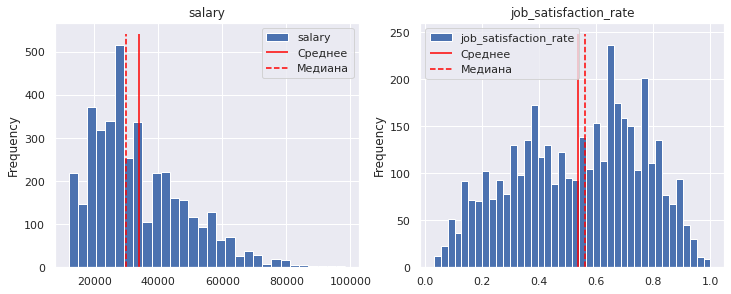

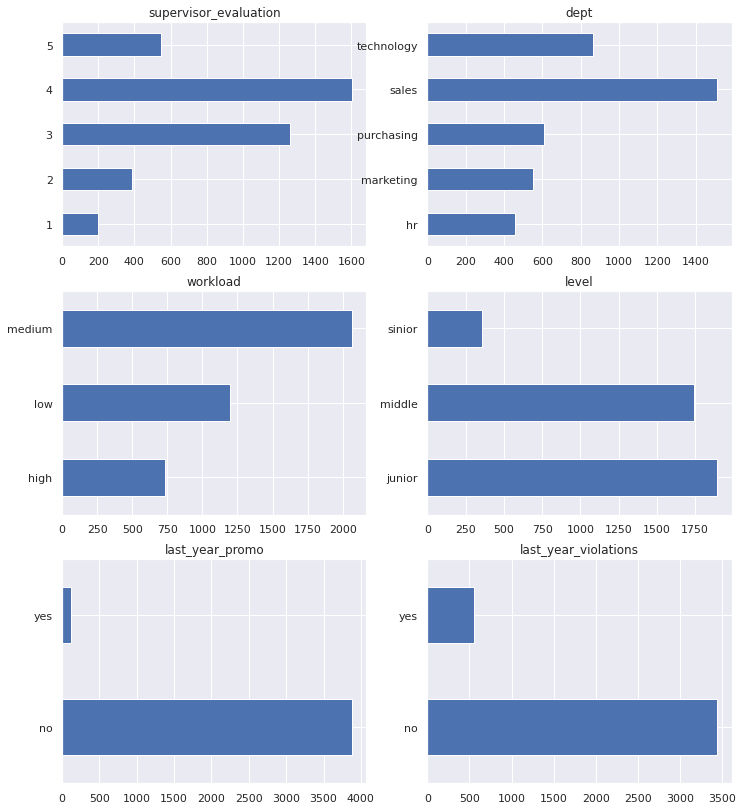

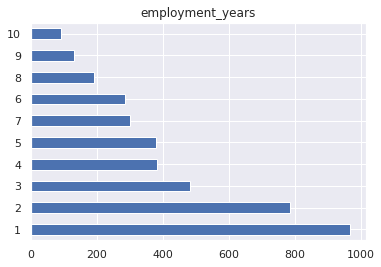

In [11]:
dataset_present(ds_train_sat)

Больше всего в компании сотрудников, устроившихся недавно, звучит логично. Вместе с увеличением длительности работы падает кол-во сотрудников.

Зарплата, ожидаемо, концентрируется ближе к минимальным значениям, в компании больше людей с низкой зарплатой.

Уровень удовлетворенности имеет 2 пика. Удовлетворённость сотрудника чаще либо немного выше средней, либо немного ниже, реже - колеблется около 0.5, или сильно склоняется в одну из двух сторон.

Самый крупный отдел в компании - отдел продаж.

Повышения выдаются неохотно. 

Также неохотно происходят нарушения трудового договора. 

Распределение уровня должностей похоже на правдивое. Ошибка в названии 'senior'. Значения называются 'sinior'.

Барплот оценки качества работы показал ту-же картину, что и гистограмма. Значения в действительности распределены между пятью категориями. 

Уровень загруженности тоже не даёт повода заподозрить здесь ошибку.

В данных отсутствуют аномалии, отлично. Исправим ошибку в названии уровня должности, а затем посмотрим на тестовые данные.

In [12]:
ds_train_sat.loc[ds_train_sat['level'] == 'sinior', 'level'] = 'senior'
ds_train_sat['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> 
    
1. `employment_years` и `supervisor_evaluation` - дискретные признаки, для их анализа нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать `sns.countplot`.
    
2. Признак `id` не должен участвовать в анализе: `id` - случайный набор символов, и потенациальная зависимимость увольнения от `id` также будет случайной, а фактически это не имеет смысла. 

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Сделал барплоты для категориальных признаков, айди теперь в индексах.
</div>

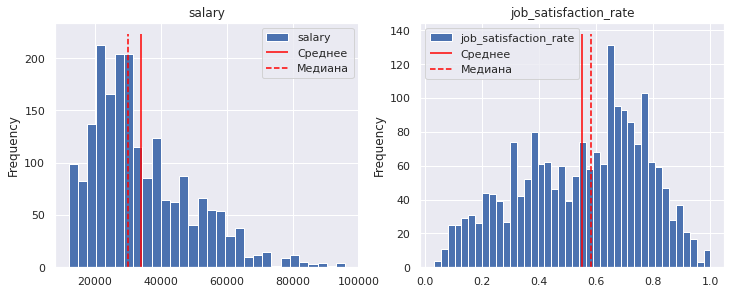

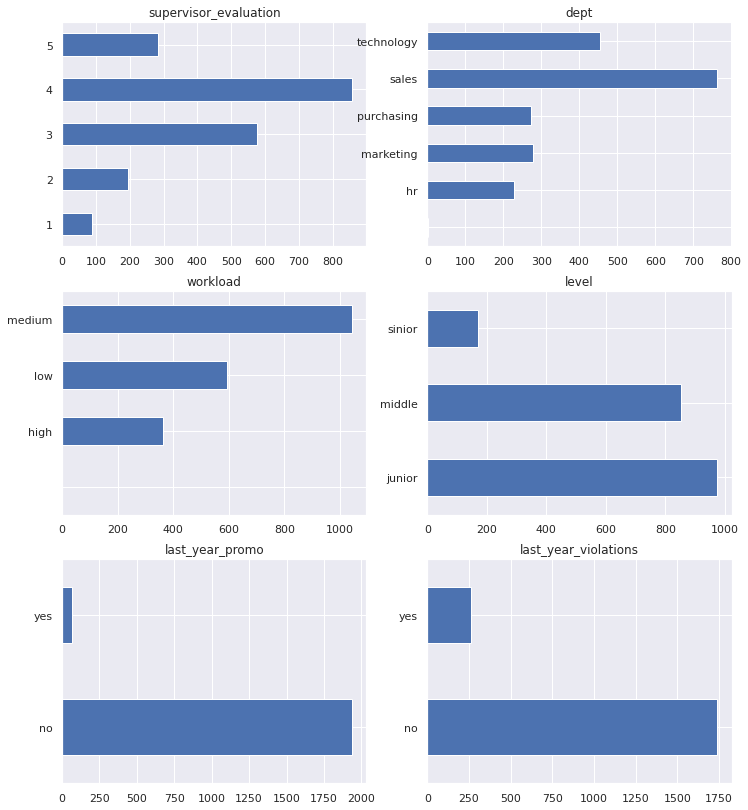

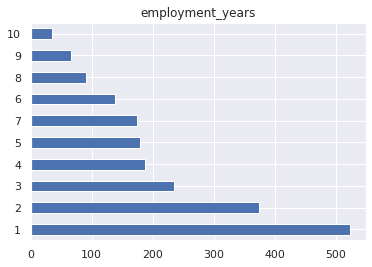

In [13]:
dataset_present(X_test.join(y_test_sat))

Все распределения крайне схожи, но можно заметить пустые значения в workload и dept.

In [14]:
for i in ['workload', 'dept']:
    print(i, X_test[i].unique())

workload ['medium' 'low' 'high' ' ']
dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']


Пробелы вместо значений. Выведем проблемные записи.

In [15]:
X_test[(X_test['workload'] == ' ')|(X_test['dept'] == ' ')]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
590867,marketing,junior,,4,no,no,4,28800
822186,,middle,medium,3,no,no,4,38400


А вот и наши ошибки. Изменим пропуски на NaN

In [16]:
X_test.loc[X_test['dept'] == ' ', 'dept'] = np.nan
X_test.loc[X_test['workload'] == ' ', 'workload'] = np.nan

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
Аномалия обработана корректно. В целом она могла бы быть обработана и в `Pipeline`, при настройке энкодеров на обработку новых значений признаков, которые не были на момент обучения энкодера.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Также можно было бы исправить ошибку в `sinior`.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> При обработке аномалии стоит явно привязываться к некорректному значению - замена по индексу не будет работать, если перемешать наблюдения в таблице.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Поправил название уровня должности, поменял привязку на некорректные значения вместо айди.
</div>

In [17]:
for i in ['dept', 'workload']:
    print(X_test[i].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


### Исследовательский анализ

In [18]:
test_full = X_test.join(y_test_sat) # Полный датасет тестовых данных. Не будет использоваться для обучения, только для анализа

На распределения данных мы уже посмотрели на этапе предобработки. Вернёмся к количественным признакам и взглянем на выбросы, построив ящиковые диаграммы для тренировочных и тестовых данных.

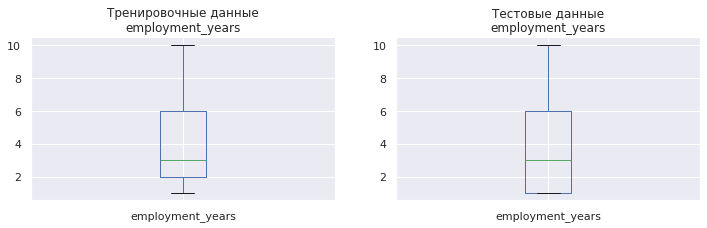

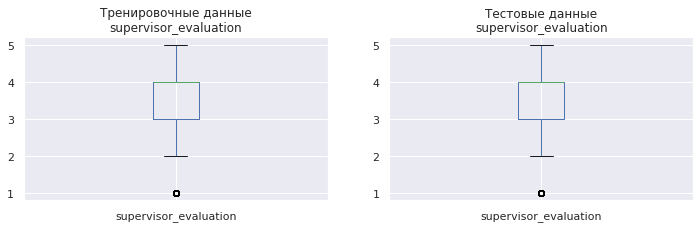

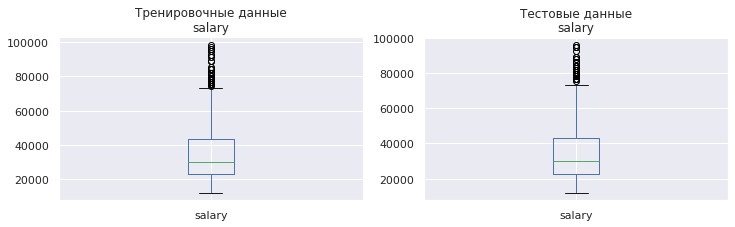

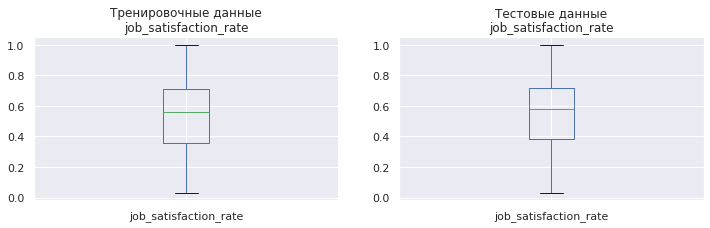

In [19]:
plot_names = ['Тренировочные данные', 'Тестовые данные']

for i in ds_train_sat.select_dtypes(include='number').columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    
    for j, k in enumerate([ds_train_sat, test_full]):
        k[i].plot(kind='box', title=i, ax=axes[j])
        axes[j].set_title(plot_names[j]+'\n'+i)
    plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Аналогично по `id`. Также следует убрать пустой график.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Убрал.
</div>

В значениях зарплаты много выбросов - сотрудники, чья зарплата выше 70.000 выбиваются из общей картины, но нам нельзя пренебречь этими значениями, иначе модель будет плохо предсказывать уход сотрудников с высокой зарплатой. 

Также имеются выбросы в значениях оценки качества работы. Низкие значения ставятся достаточно редко, из-за чего единица находится за пределами нижнего уса, они нам также пригодятся.

В тестовых данных немного больше сотрудников, устроившихся недавно, из-за чего нижняя граница ящика упирается в минимальное значение. В остальном распределения двух датасетов схожи.

Теперь займёмся корреляцией. Начнём с матрицы корреляции Спирмана.

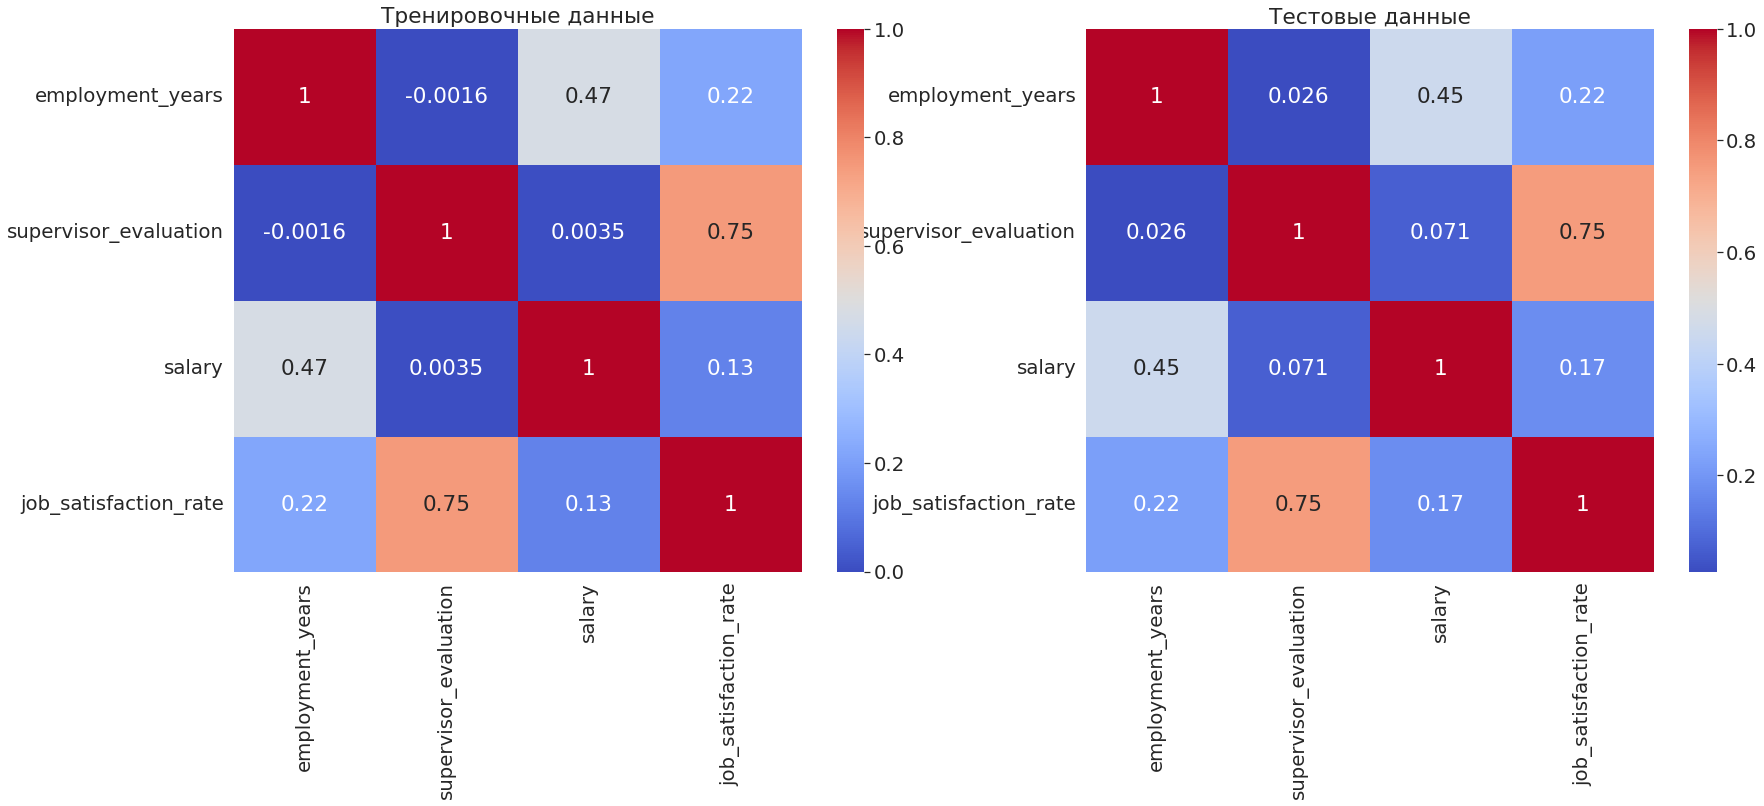

In [20]:
sns.set(font_scale=1.8)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))

for j, i in enumerate([ds_train_sat, test_full]):
    sns.heatmap(i.corr(method='spearman'), annot=True, cmap='coolwarm', ax=axes[j]);
    axes[j].set_title(plot_names[j])
sns.set(font_scale=1)

На уровень удовлетворённости прямо и достаточно сильно влияет оценка качества работы сотрудника. И имеется слабая корреляция с длительностью работы и зарплатой.

Также слабо коррелируют между собой зарплата и длительность работы, но до мультиколлинеарности им ещё далеко.

Теперь посмотрим на матрицу взаимосвязи библиотеки phik. Здесь мы сможем увидеть также и зависимости категориальных признаков

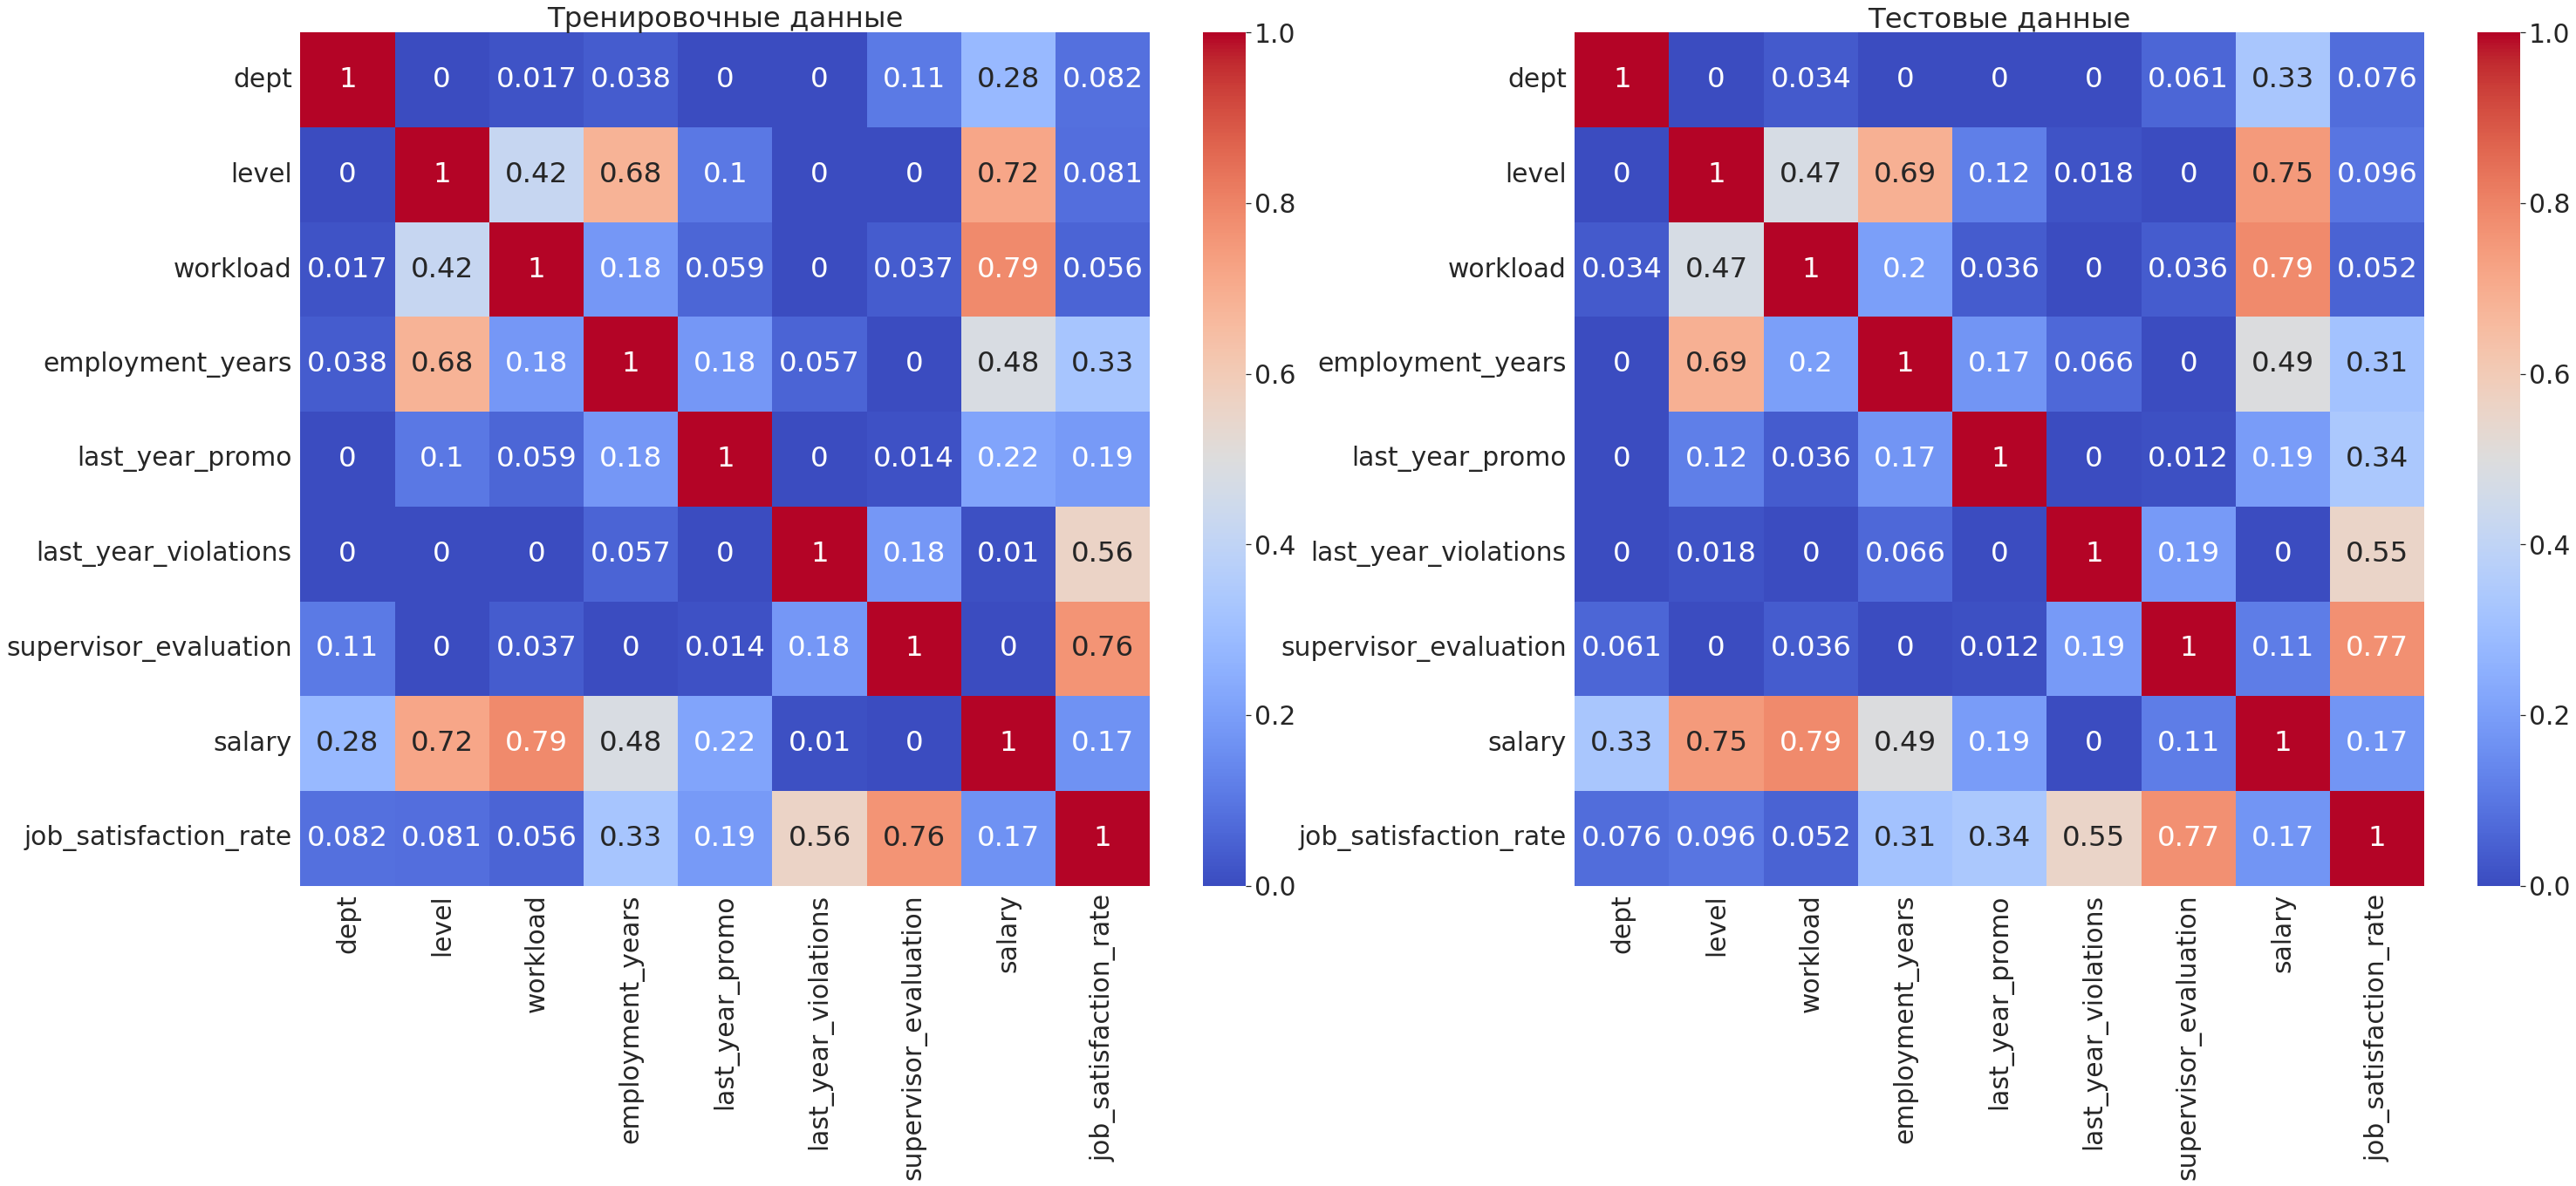

In [21]:
sns.set(font_scale=2.7)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(48, 18))

for j, i in enumerate([ds_train_sat, test_full]):
    sns.heatmap(i.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, cmap='coolwarm', ax=axes[j]);
    axes[j].set_title(plot_names[j])
sns.set(font_scale=1)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> `employment_years` и `supervisor_evaluation` - дискретные признаки, их не нужно передавать в `interval_cols`. Из анализа корреляции также следует исключить `id`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправил.
</div>

Похожая картина, что и в матрице корреляции Спирмена, также видна зависимость удовлетворенности от наличия нарушений.

Проследим за более наглядными зависимостями.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Есть анализ корреляции - молодец, что используешь `phik` для анализа и нелинейных зависимостей, а также настраиваешь `interval_cols` для корректной оценки корреляции для переменных разного типа.

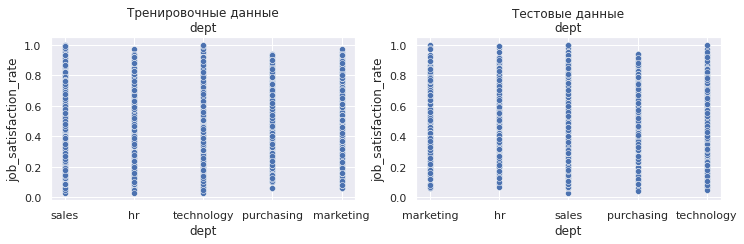

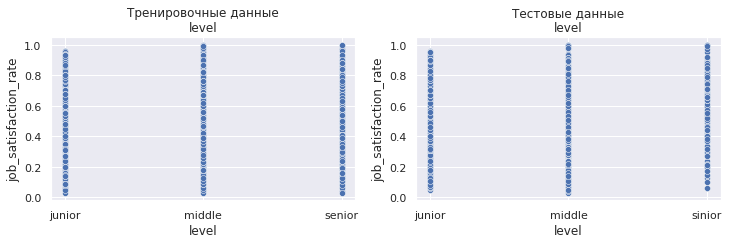

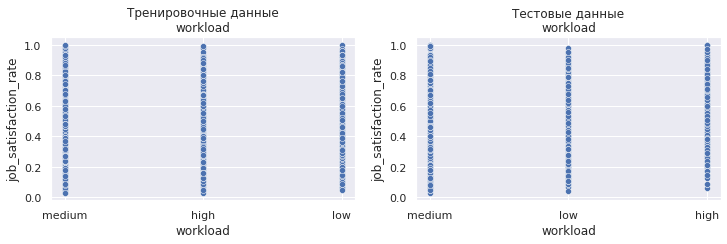

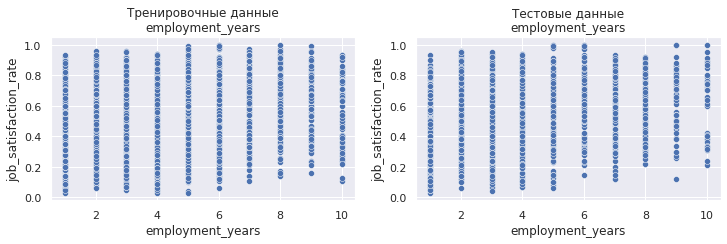

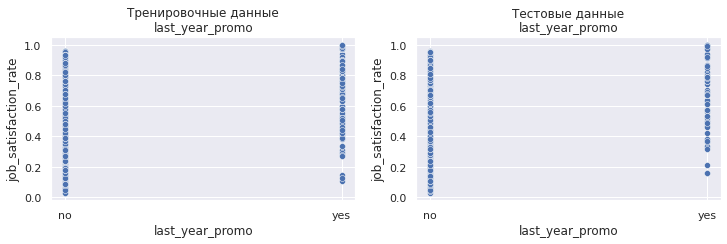

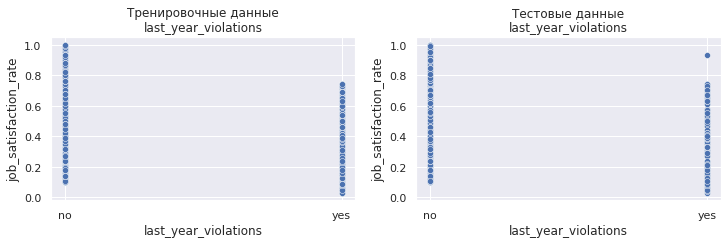

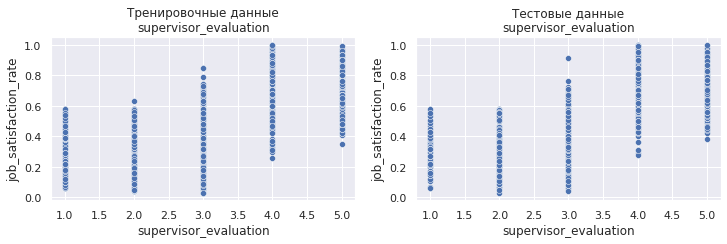

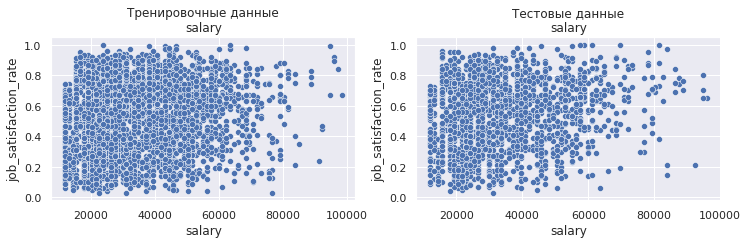

In [22]:
for i in ds_train_sat.columns.drop('job_satisfaction_rate'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    
    for j, k in enumerate([ds_train_sat, test_full]):
        sns.scatterplot(data=k, x=i, y='job_satisfaction_rate', ax=axes[j])
        axes[j].set_title(plot_names[j]+'\n'+i)
    plt.show()

Видно, что после 6 лет работы в компании, сотрудники почти никогда не бывают полностью разочарованы в своей работе. 

Так-же те, кто за последний год получил повышение, тоже редко пребывают в унынии. 

Противоположная картина у сотрудников, нарушивших трудовой договор за последний год. Они почти никогда не бывают полностью удовлетворены. А те кто его не нарушал - почти никогда не бывают полностью разочарованы.

Оценка качества работы выше 3 крайне позитивно влияет на удовлетворенность сотрудника.

Распределения данных тренировочной и тестовой выборки крайне схожи.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Хороший EDA `train` выборки.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Аналогичный анализ (EDA и корреляциия) нужно провести для `test` выборки: так как мы не сами занимались разделением данных на выборки, мы должны убедиться, что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на `test` выборке, будет корректной.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Сделал такой-же анализ для тестовой выборки, разбил все графики на пары сабплотов.
</div>

### Подготовка данных

Для начала создадим пайплайны для кодирования данных. У нас много категориальных признаков, и у некоторых из них есть последовательные значения. Например, уровень должности. Для таких признаков используем `OrdinalEncoder`, он назначит каждому значению число согласно переданной последовательности.

In [23]:
ord_pipe = Pipeline([
    ('impute_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[
        ['junior', 'middle', 'senior'],
        ['low', 'medium', 'high']
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('impute_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

Все остальные признаки закодируем при помощи `OneHotEncoder`.

In [24]:
ohe_pipe = Pipeline([
    ('impute_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> `OneHotEncoder` нужно настроить так, чтобы он обрабатывал новые значения признаков, а не выбрасывал ошибку - при текущей настройке `handle_unknown` в случае возникновения новых значений у признаков, которых не было в `train`, модель будет падать, а для многих случаев важна бесперебойность решений.
    
Может понадобиться обновление библиотеки `sklearn`, так как в ранних версиях параметры `handle_unknown` и `drop` конфликтовали друг с другом, но в актуальной версии библиотеки такой проблемы нет.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Добавил проверку версии и обновление sklearn в начало, там где импорты. Добавил `handle_unknown='ignore'` в инициализацию OHE
</div>

Нам потребуется расфасовать названия столбцов, что и где мы будем кодировать/масштабировать. И сразу-же объединим все пайплайны при помощи `ColumnTransformer`

In [25]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

data_preprocessor = ColumnTransformer([
    ('ohe_encode', ohe_pipe, ohe_columns),
    ('ord_encode', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Инструменты трансформации выборок нельзя обучать на `test`: так как `test` выборка имитирует поток реальных данных, с которыми работает модель, то, во-первых, `test` выборки в реальной среде работы модели не будет, и твой пайплайн с моделью упадёт, во-вторых, так мы даём модели данные из будущего, которые в нормальных условиях она не могла бы увидеть - в `test` вполне могут быть новые категории, отсутствующие в `train` (если говорить про кодирование), или распределение переменных в `test` может сильно отличаться от распределения в `train` (если говорить про стандартизацию).
    
Единственно верный порядок работы с такими инструментами - обучаемся на `train` (для `train` можно использовать `fit_transform()`), и уже обученным на `train` инструментом изменяем выборки `train`, `test` и `valid` (если выделялась).

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
    
Убрал отдельный SimpleImputer. Замена пропусков теперь везде происходит в пайплайнах.
</div>

На этом подготовка данных завершена, у нас есть пайплайны для препроцессинга, и на следующем шаге мы объединим его с самой моделью.

### Обучение моделей

Для начала проверим тренировочные данные на дубликаты, которые могли появиться в результате предобработки. Они не принесут пользы при обучении, и будут только мешать.

In [26]:
ds_train_sat.duplicated().sum()

245

245 идентичных записей. От всех них можно избавиться.

In [27]:
ds_train_sat = ds_train_sat.drop_duplicates()
ds_train_sat.duplicated().sum()

0

Теперь разделим тренировочную выборку на входные и целевые признаки.

In [28]:
X_train = ds_train_sat.drop(['job_satisfaction_rate'], axis=1)
y_train = ds_train_sat['job_satisfaction_rate']

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> После удаления `id` (но до удаления `job_satisfaction_rate`) нужно проверить наличие новых дубликатов в данных: так как мы удалили часть лишних признаков, у нас могут появиться новые явные дубликаты: чем меньше признаков остаётся, тем выше шанс, что значения остальных признаков будут пересекаться. При этом ценности для модели такие наблюдения уже не принесут, поэтому стоит проверить дубликаты также в финальной версии таблицы.
    
При этом важно проверить только `train`: наличие дубликатов в `test` нам никак не мешает, но это правильное решение с точки зрения неприкосновенности `test`, ведь реальный поток данных (который имитирует `test` выборка) мы исправить не сможем. А вот наличие дубликатов в `train` не только не принесёт пользы модели, но может и навредить.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
    
Убрал дубликаты перед разделением данных.
</div>

Теперь создадим финальные пайплайны. Мы проверим 2 модели - линейную регрессию и регрессор дерева решений. Для каждого создадим свой итоговый пайплайн, и позже сравним значения метрик.

In [29]:
pipe_linear = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Кстати о метрике - мы будем использовать SMAPE. Это симметричная средняя абсолютная процентная ошибка, её нет в библиотеке sklearn, поэтому создадим её сами. Для этого инициализируем функцию с расчётами.

In [30]:
def smape(true, pred):
    true = true.reset_index(drop=True)
    if type(pred) != pd.core.series.Series:
        pred = pd.Series(pred)
    error = np.abs(true - pred)
    scale = (np.abs(true) + np.abs(pred)) / 2
    return np.mean(error / scale) * 100

И используем `make_scorer`, передав ему нашу функцию, и параметр `greater_is_better` равный False. SMAPE показывает процент содержания ошибок в ответах модели. Соответственно, высокое значение SMAPE - это значит, что модель работает плохо.

In [31]:
smape_score = make_scorer(smape, greater_is_better=False)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть функция для оценки `sMAPE`, а также пользовательский скорринг для кросс-валидации - супер!
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>
Для линейной регрессии оптимизировать гиперпараметры не совсем корректно: так как её обучение сводится к решению системы линейных уравнений, то настройка гиперпараметров зависит от того, каким образом были подготовлены данные. Обратись, пожалуйста, к документации и выполни настройку гиперпараметров из сетки согласно описанию: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.
    
Сами гиперпараметры нужно настроить в момент инициализации модели. 
    
Для проведения кросс-валидации можно просто оставить пустой словарь для линейной регрессии, и для неё будет просто выполнена кросс-валидация - так твоё решение не нужно будет сильно перестраивать. Но сами гиперпараметры нужно задать модели в момент инициализации.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> `cv=8` - избыточное решение, которое может увеличивать работу кода. Достаточно 3-5 фолдов для получения стабильной метрики.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> У `OptunaSearchCV` нужно настраивать `random_state` для воспроизводимости результата.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Решил убрать подбор гиперпараметров для линейной регрессии, в любом случае подбирать там нечего. Оставил простой вывод метрики на кросс-валидации ниже. cv поменял на 5.
</div>

Создаём объект OptunaSearchCV, он будет заниматься для нас поиском лучших параметров. Для этого ему понадобится сетка параметров param_grid.

In [32]:
param_grid_tree={
    'model__max_depth':distributions.IntDistribution(3, 20),
    'model__min_samples_split':distributions.IntDistribution(2, 15),
    'model__min_samples_leaf':distributions.IntDistribution(2, 15)
}

cval_tree = OptunaSearchCV(
    pipe_tree,
    param_distributions=param_grid_tree,
    scoring=smape_score,
    n_jobs=-1,
    cv=5,
    n_trials=18,
    random_state=RANDOM_STATE
) 

/tmp/ipykernel_1958/427999938.py:7: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  cval_tree = OptunaSearchCV(


А теперь - запустим обучение моделей. Линейной регрессии хватит простой кросс-валидации, для дерева решений подберём гиперпараметры.

In [33]:
abs(cross_val_score(pipe_linear, X_train, y_train, scoring=smape_score, cv=5).mean())

25.005621272180875

25%. Результат не самый хороший, возможно дерево решений покажет результат получше.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Понимание природы минуса - верное, но минус следует спрятать при выводе метрики на экран - с точки зрения заказчика метрика не может быть отрицательной.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Сделал вывод метрики по модулю, убрал лишнее описание.
</div>

In [34]:
%time cval_tree.fit(X_train, y_train)
print('Лучшая оценка:', abs(cval_tree.best_score_), 'с параметрами - ')
cval_tree.best_params_

[I 2024-05-21 05:25:22,312] A new study created in memory with name: no-name-d1417930-d7f9-4b8d-8b05-6f7387c73324
[I 2024-05-21 05:25:23,942] Trial 1 finished with value: -16.789436349493815 and parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__min_samples_leaf': 13}. Best is trial 1 with value: -16.789436349493815.
[I 2024-05-21 05:25:23,968] Trial 0 finished with value: -22.691738943050943 and parameters: {'model__max_depth': 3, 'model__min_samples_split': 15, 'model__min_samples_leaf': 4}. Best is trial 1 with value: -16.789436349493815.
[I 2024-05-21 05:25:24,015] Trial 7 finished with value: -15.6536777798868 and parameters: {'model__max_depth': 18, 'model__min_samples_split': 7, 'model__min_samples_leaf': 6}. Best is trial 7 with value: -15.6536777798868.
[I 2024-05-21 05:25:24,051] Trial 6 finished with value: -15.161442028196984 and parameters: {'model__max_depth': 16, 'model__min_samples_split': 8, 'model__min_samples_leaf': 2}. Best is trial 6 with v

CPU times: user 3.54 s, sys: 398 ms, total: 3.93 s
Wall time: 3.97 s
Лучшая оценка: 15.161442028196984 с параметрами - 


{'model__max_depth': 16,
 'model__min_samples_split': 8,
 'model__min_samples_leaf': 2}

~15.2%. Результат хороший, но не проходит по критерию успеха совсем немного. Посмотрим, улучшится-ли метрика на тестовых данных.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Найдена лучшая модель.

In [35]:
# Оба датасета перемешаны, перед отправкой сортируем их по id
smape(
    y_test_sat.sort_index().reset_index(drop=True)['job_satisfaction_rate'], # Сортируем тестовые данные по айди и сбрасываем их
    pd.Series(cval_tree.predict(
        X_test.sort_index()
        .reset_index(drop=True))))

13.83731995973351

~13.9%. А нам нужно было 15 или ниже. Но перед тем, как объявлять, что модель готова, сравним значение её метрики с моделью-болванкой, всегда предсказывающей медианное значение.

In [36]:
dummy_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DummyRegressor(strategy='median'))
])

dummy_pipe.fit(X_train, y_train)

smape(
    y_test_sat.sort_index().reset_index(drop=True)['job_satisfaction_rate'], # Сортируем тестовые данные по айди и сбрасываем их
    pd.Series(dummy_pipe.predict(
        X_test.sort_index()
        .reset_index(drop=True))))

37.77281981888386

Разница в метриках очевидна, модель преодолела порог успеха, и мы можем считать её готовой.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Лучшую модель оценили на `test` - отличный результат!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>
Очень важно также проверить лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки? 
    
В качестве константной модели можно использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) -  эта модель как раз создана для генерирования константных предсказаний.
    
Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на `train`, делает нашу работу лучше.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Сделал вывод метрики на тестовых данных для dummy-модели и обновил выводы.
</div>

Итого мы провели подбор гиперпараметров для двух моделей - линейной регрессии и регрессора дерева решений, выбрали лучшую модель - дерево решений с соответствующими гиперпараметрами, и на основе её предсказаний на тестовых данных получили значение метрики SMAPE 13.9%.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Молодец, что не забываешь про промежуточные выводы.

## Предсказание увольнения сотрудника из компании

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Для этой задачи аналогичны все замечания из предыдущей в части аналогичных активностей.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Поправил что нашёл.
</div>

Теперь переходим ко второй задаче - нам необходимо создать модель-классификатор, которая предскажет увольнение того или иного сотрудника. Пройдёмся по новой по всем пунктам, и первая на очереди - загрузка данных

### Загрузка и ознакомление с данными

Входные данные тестовой выборки остались прежними. А вот тренировочные и целевые тестовые необходимо загрузить.

In [37]:
try:
    ds_train_ret = pd.read_csv('/datasets/train_quit.csv', index_col='id')
except:
    ds_train_ret = pd.read_csv('datasets/train_quit.csv', index_col='id')
dataset_info(ds_train_ret)

Количество дубликатов: 1413
Длина датасета: 4000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [38]:
try:
    y_test_ret = pd.read_csv('/datasets/test_target_quit.csv', index_col='id')
except:
    y_test_ret = pd.read_csv('datasets/test_target_quit.csv', index_col='id')
dataset_info(y_test_ret)

Количество дубликатов: 1998
Длина датасета: 2000


,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


,quit
count,2000
unique,2
top,no
freq,1436


Пропусков нет, все типы данных в норме. Много дубликатов, но мы с вами уже почти наверняка знаем, что это связано с формальным отсутствием айди.

### Предобработка данных

Теперь посмотрим на наличие выбросов и неявных дубликатов.

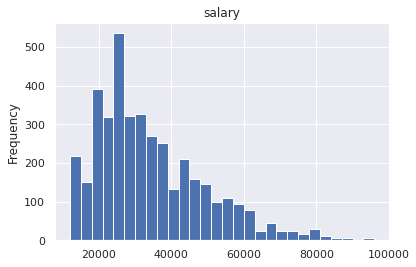

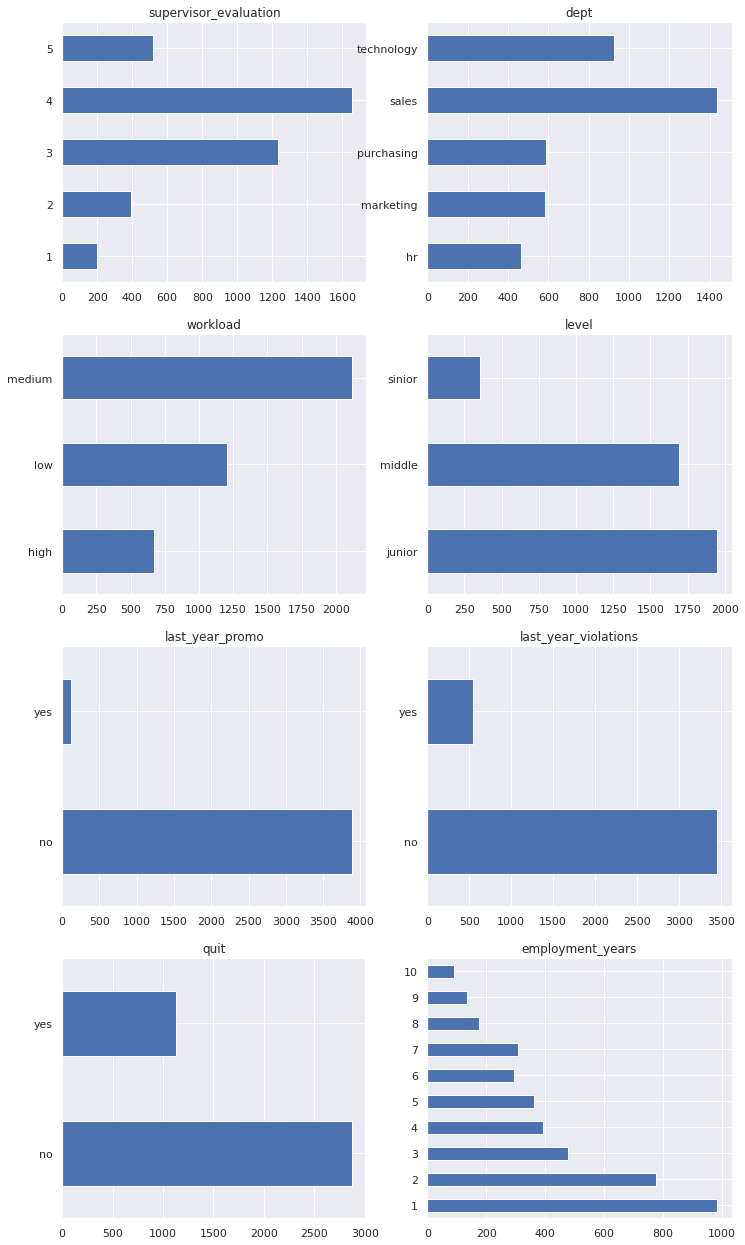

In [39]:
ds_train_ret['salary'].plot(kind='hist', title='salary', bins=28)
plt.show()


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 22))

for j, i in enumerate(['supervisor_evaluation', 'dept', 'workload', 'level', 'last_year_promo', 'last_year_violations', 'quit', 'employment_years']):
     ds_train_ret[i].value_counts().sort_index().plot(kind='barh', title=i, ax=axes[j//2, j%2])
plt.show()


Ни выбросов, ни неявных дубликатов в новых данных нет.

### Исследовательский анализ

#### Изучение данных

Теперь посмотрим на распределение количественных признаков под другим углом, заодно проверим, сохранилась-ли тенденция по сравнению с данными, на которых мы обучали регрессионную модель.

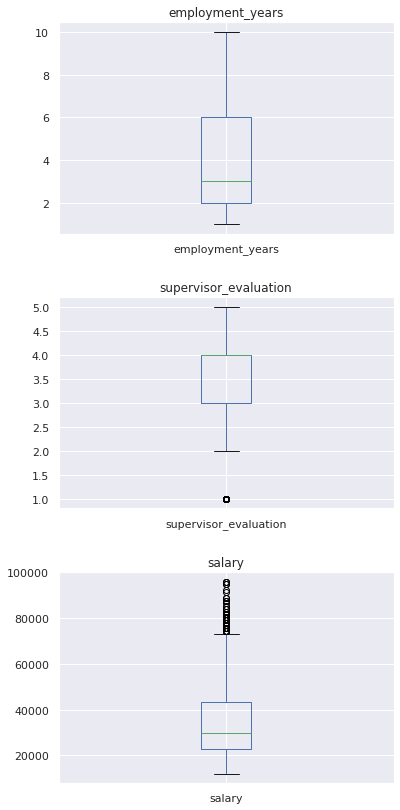

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 14))

for j, i in enumerate(ds_train_ret.select_dtypes(include='number').columns):
    ds_train_ret[i].plot(kind='box', title=i, ax=axes[j])
plt.subplots_adjust(hspace=0.3)

Абсолютно идентичная картина. В нашем случае это хорошо. Теперь корреляция. Целевой признак - категориальный, и смысла от корреляции Пирсона или Спирмена не будет. Отобразим сразу матрицу взаимосвязи Phik.

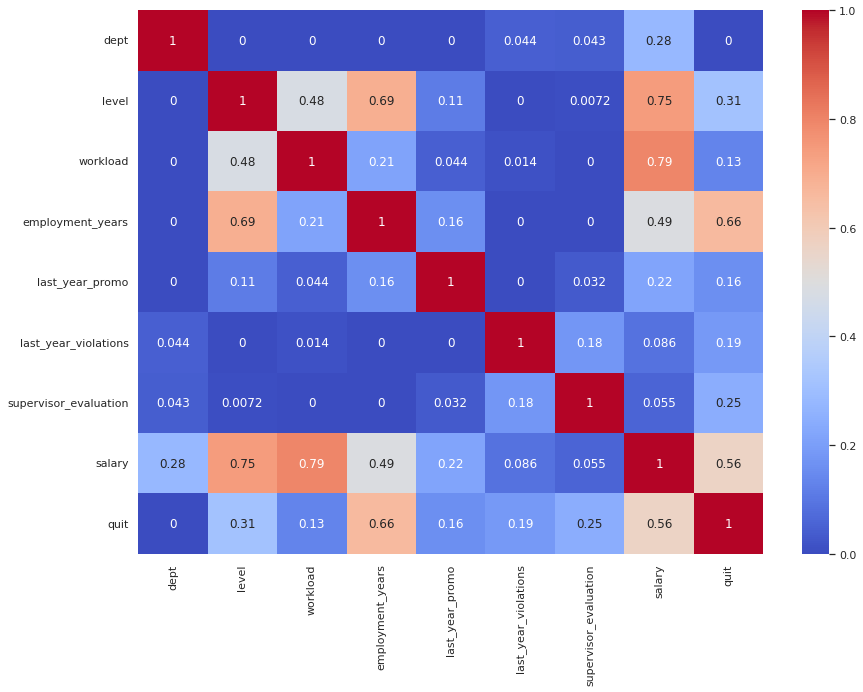

In [41]:
plt.figure(figsize=(14, 10))
sns.heatmap(ds_train_ret.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, cmap='coolwarm');

Все признаки так или иначе влияют на целевой. Кроме одного - отдела сотрудника. Он абсолютно никак не влияет на целевой признак.

#### Составление портрета уволившегося сотрудника

Теперь нам необходимо ответить на вопрос - как выглядит, кем работает и как себя чувствует тот человек, что планирует уволиться. Мы составим портрет увольняющегося сотрудника, и более наглядно проследим взаимосвязи с целевым признаком.

Цифры - это хорошо, но наглядней взаимосвязь признаков отобразят графики. 

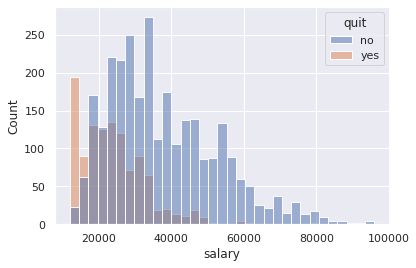

In [42]:
sns.histplot(data=ds_train_ret, x='salary', hue='quit');

Распределение зарплат увольняющихся сотрудников слегка сдвинуто влево, а также виден пик на минимальных значениях.

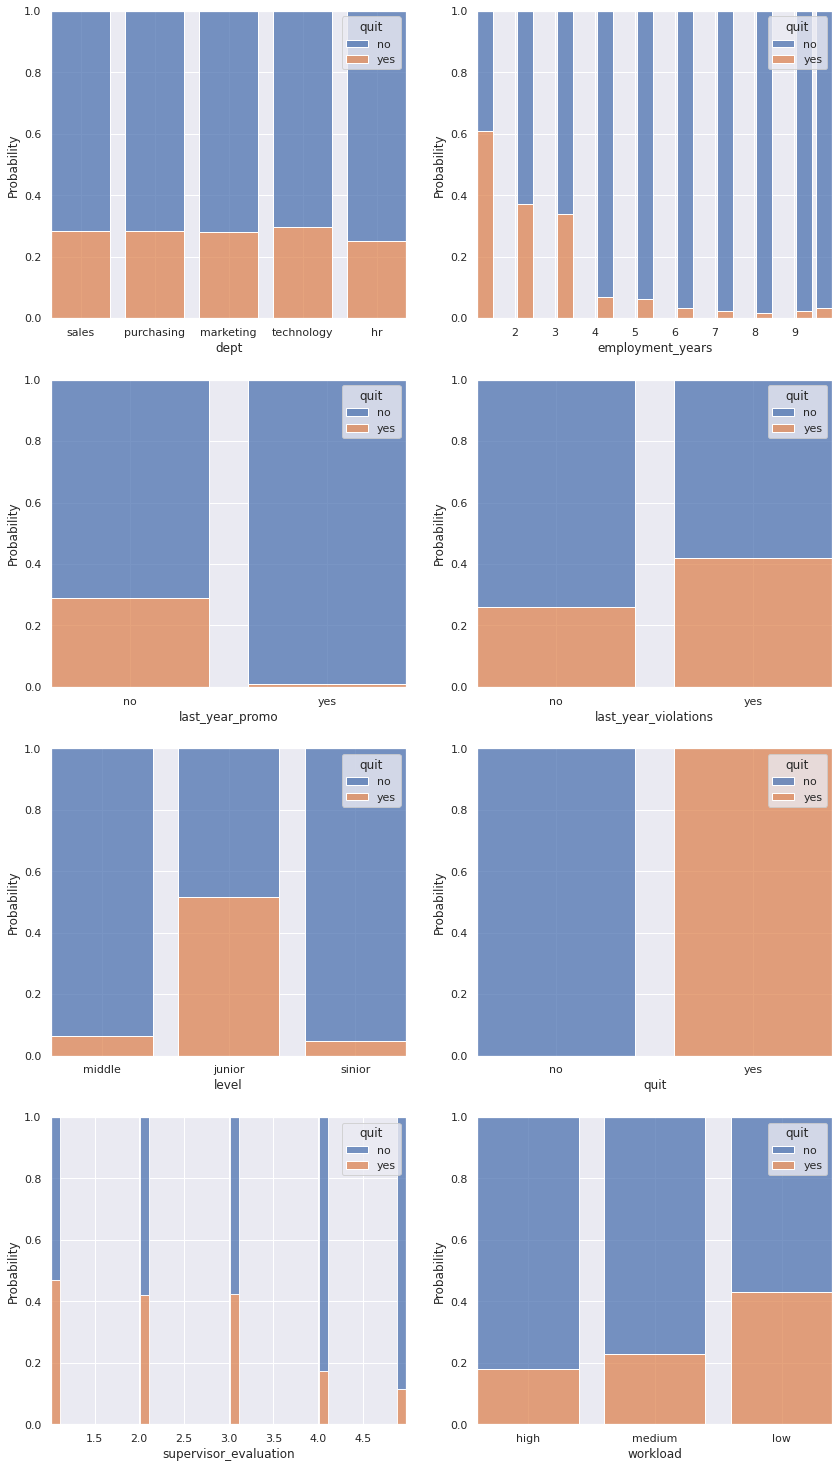

In [43]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 26))

for j, i in enumerate(ds_train_ret.select_dtypes(exclude='number').columns.union(['employment_years', 'supervisor_evaluation'])):
    sns.histplot(ds_train_ret, x=i, hue='quit', ax=axes[j//2, j%2], stat="probability", multiple="fill", shrink=.8)

И уже можно делать выводы.

Среднестатистический сотрудник, собирающийся уволиться, скорее всего:
- Устроился недавно, или проработал менее 5 лет.
- Имеет зарплату немного ниже медианной.
- Начальство оценивает его работу на 3/5.
- Работает на младшей должности
- Имеет малый уровень нагрузки
- Не получал повышения в последнее время
- Нарушал трудовой договор

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Проанализирован портрет уволившегося сотрудника.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>  Анализ категориальных/дискретных признаков нужно сделать с помощью относительных величин - оперировать абсолютными величинами не всегда удобно, так как в зависимости от масштаба исследования (компания на 100 человек и компания на 100 000 человек, например) результаты могут быть более или менее интерпретируемыми. Для категориальных/дискретных признаков мы можем использовать `value_counts(normalize=True)`, для непрерывных можно посчитать и сравнить средние.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Нашёл немножко костыльное решение, но вроде работает. Формально это гистограммы, а не барплоты, но задачу свою выполняют, и выглядят неплохо.
</div>

#### Влияет-ли удовлетворённость работника на желание уволиться?

Таков вопрос аналитиков, и наша задача дать на него ответ. Визуализируем зависимость одного от другого, используя тестовые данные с обоими признаками.

In [44]:
test_full = test_full.join(y_test_ret)
test_full.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no


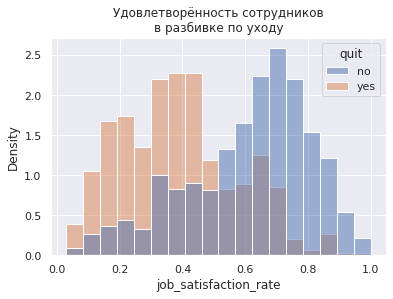

In [45]:
sns.histplot(data=test_full, x='job_satisfaction_rate', hue='quit', stat='density', common_norm=False)
plt.title('Удовлетворённость сотрудников\nв разбивке по уходу');

Ответ выглядит очевидным, но подтвердим наши предположения при помощи статистики. А именно - ттеста Стьюдента. Для начала нам надо узнать, как сильно различаются дисперсии генеральных совокупностей. Для этого проверим соотношение дисперсий выборок. Если соотношение меньше 4 - мы предположим, что дисперсии равны.

In [46]:
print('Соотношение дисперсии большей выборки к дисперсии меньшей:', np.var(test_full.loc[test_full['quit']=='no', 'job_satisfaction_rate'])/np.var(test_full.loc[test_full['quit']=='yes', 'job_satisfaction_rate']))

Соотношение дисперсии большей выборки к дисперсии меньшей: 1.1528119661055445


Дисперсии равны, можем приступать к независимому правостороннему ттесту.

Наша нулевая гипотеза: Среднее значение удовлетворённости уволившихся сотрудников, и не уволившихся, равны.

Альтернативная гипотеза: Среднее значение удовлетворённости не уволившихся сотрудников больше среднего значения удовлетворённости уволившихся.

За уровень стат. значимости возьмём 5%.

In [47]:
alpha = .5
arr1 = test_full.loc[test_full['quit']=='no', 'job_satisfaction_rate']
arr2 = test_full.loc[test_full['quit']=='yes', 'job_satisfaction_rate']


ttest = ttest_ind(
    arr1, 
    arr2,
    random_state=RANDOM_STATE,
    alternative='greater'
)
print(f'pvalue:{ttest.pvalue}\nСреднее первой выборки: {arr1.mean().round(1)}')
print(f'Среднее второй выборки: {arr2.mean().round(1)}')
if ttest.pvalue<alpha:
    print('Нулевая гипотеза отвергается в пользу альтернативной')
else:
    print('Нулевая гипотеза не может быть опровергнута')

pvalue:6.155610332585965e-105
Среднее первой выборки: 0.6
Среднее второй выборки: 0.4
Нулевая гипотеза отвергается в пользу альтернативной


Удовлетворённость не уволившихся сотрудников в среднем больше, чем уволившихся. Теперь не только на словах, но и по результатам статистического анализа.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Не забывай подписывать название на графиках.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Поправил.
</div>

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследовано распределение удовлетворённости в зависимости от факта ухода.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Чуть более интересным решением, позволяющим выполнить оценку не "на глаз", а более статистически достоверно, было бы использование статистического теста (например, `ttest`) для сравнения распределений в выборках.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Провёл ттест, поменял вывод.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Здесь мы имеем дело с анализом распределения непрерывной величины, а сам анализ проводится по двум выборкам разного размера - для анализа их распределения стоит использовать нормированную гистограмму (например, `shs.histplot()` с параметрами `stat='density', common_norm=False` или `sns.kdeplot()`): гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений. Обрати также внимание, что при использовании нормированных гистограмм по оси Y будет уже не частота значений, а плотность распределения.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправил.
</div>

### Добавление нового признака

Раз мы выявили новую зависимость - грех будет ею не воспользоваться. Спрогнозируем удовлетворённость сотрудников на новой тренировочной выборке. Это будет наш новый входной признак

In [48]:
ds_train_ret['job_satisfaction_rate'] = cval_tree.predict(ds_train_ret.drop('quit', axis=1))
ds_train_ret.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.635000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


Не отходя далеко, спрогнозируем значения и для тестовых данных. В полевых условиях их не получится получить как-либо иначе.

In [49]:
X_test['job_satisfaction_rate'] = cval_tree.predict(X_test)
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.885000
686555,hr,junior,medium,1,no,no,4,30000,0.682222
467458,sales,middle,low,5,no,no,4,19200,0.643333
418655,sales,middle,low,6,no,no,4,19200,0.655000
789145,hr,middle,medium,5,no,no,5,40800,0.825556


Признак готов, перейдём к пайплайнам.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В `train` добавлен новый признак на основе предсказаний модели.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Аналогичным образом через предсказания новый признак нужно получить для `test`: реальные значения мы можем использовать для анализа исторических данных, так как они содержат важные паттерны для анализа зависимостей, которые также запоминает и модель, но чтобы иметь возможность работать с новыми работниками без исторических данных, модель должна использовать признак на основе предсказаний. 

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Добавил в тестовые данные прогнозные значения.
</div>

### Подготовка данных

Возьмём за основу пайплайны препроцессинга из первой задачи, и добавим туда новый признак.

In [50]:
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

data_preprocessor_ret = ColumnTransformer([
    ('ohe_encode', ohe_pipe, ohe_columns),
    ('ord_encode', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

Точно так-же удалим дубликаты перед разделением данных.

In [51]:
ds_train_ret.duplicated().sum()

1413

In [52]:
ds_train_ret = ds_train_ret.drop_duplicates()
ds_train_ret.duplicated().sum()

0

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Удалил дубликаты по аналогии с предыдущим обучением моделей.
</div>

Теперь отделим входные данные от целевых.  `dept` на исследовательском анализе показал нулевую корреляцию и взаимосвязь с целевым признаком. При обучении он будет только мешать, поэтому его мы не возьмём.

In [53]:
X_train = ds_train_ret.drop(['quit', 'dept'], axis=1).reset_index(drop=True)
y_train = ds_train_ret['quit']

Теперь закодируем целевой признак при помощи LabelEncoder.

In [54]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test_ret = le.transform(y_test_ret.sort_index()['quit'])
le.classes_

array(['no', 'yes'], dtype=object)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Не выполнено кодирование целевого признака - для этого нужно использовать `LabelEncoder`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Сделал.
</div>

И можем приступать к обучению моделей. За основу мы возьмём 3 модели-классификатора - k-ближайших соседей, логистическую регрессию и дерево решений. Для подбора наилучших гиперпараметров будем использовать, как обычно, OptunaSearchCV.

In [55]:
knn_ret_pipe = Pipeline([
    ('preprocessing', data_preprocessor_ret),
    ('model', KNeighborsClassifier())
])

knn_ret_grid={
    'model__n_neighbors':distributions.IntDistribution(1, 120)
}

cval_knn = OptunaSearchCV(
    knn_ret_pipe,
    param_distributions=knn_ret_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_trials=14,
    random_state=RANDOM_STATE
) 

%time cval_knn.fit(X_train, y_train)
print('Лучшая оценка:', cval_knn.best_score_, 'с параметрами - ')
cval_knn.best_params_

/tmp/ipykernel_1958/3694019111.py:10: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  cval_knn = OptunaSearchCV(
[I 2024-05-21 05:25:31,928] A new study created in memory with name: no-name-eb80cec0-6605-4b14-a325-e3af7cda5d3f
[I 2024-05-21 05:25:33,505] Trial 4 finished with value: 0.8911289014556768 and parameters: {'model__n_neighbors': 5}. Best is trial 4 with value: 0.8911289014556768.
[I 2024-05-21 05:25:33,935] Trial 3 finished with value: 0.912510004322133 and parameters: {'model__n_neighbors': 19}. Best is trial 3 with value: 0.912510004322133.
[I 2024-05-21 05:25:34,202] Trial 7 finished with value: 0.9124984912393769 and parameters: {'model__n_neighbors': 23}. Best is trial 3 with value: 0.912510004322133.
[I 2024-05-21 05:25:35,446] Trial 2 finished with value: 0.9094152284000412 and parameters: {'model__n_neighbors': 68}. Best is trial 3 with value: 0.912510004322133.
[I 2024-05-21 05:25:35,501] Trial 

CPU times: user 4.32 s, sys: 668 ms, total: 4.98 s
Wall time: 5 s
Лучшая оценка: 0.912510004322133 с параметрами - 


{'model__n_neighbors': 19}

In [56]:
log_ret_pipe = Pipeline([
    ('preprocessing', data_preprocessor_ret),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

%time print('Средняя оценка:', cross_val_score(log_ret_pipe, X_train, y_train, scoring='roc_auc', cv=8).mean())

Средняя оценка: 0.9016236206146997
CPU times: user 703 ms, sys: 862 ms, total: 1.56 s
Wall time: 1.49 s


In [57]:
tree_ret_pipe = Pipeline([
    ('preprocessing', data_preprocessor_ret),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

tree_ret_grid={
    'model__max_depth':distributions.IntDistribution(3, 8),
    'model__min_samples_split':distributions.IntDistribution(2, 10),
    'model__min_samples_leaf':distributions.IntDistribution(2, 10)
}

cval_treec = OptunaSearchCV(
    tree_ret_pipe,
    param_distributions=tree_ret_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_trials=10,
    random_state=RANDOM_STATE
) 

%time cval_treec.fit(X_train, y_train)
print('Лучшая оценка:', cval_treec.best_score_, 'с параметрами - ')
cval_treec.best_params_

/tmp/ipykernel_1958/3380796229.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  cval_treec = OptunaSearchCV(
[I 2024-05-21 05:25:38,511] A new study created in memory with name: no-name-e5fb1fb4-5560-4149-96d9-0ca84e7f39f5
[I 2024-05-21 05:25:40,175] Trial 0 finished with value: 0.8999491594938576 and parameters: {'model__max_depth': 3, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4}. Best is trial 0 with value: 0.8999491594938576.
[I 2024-05-21 05:25:40,317] Trial 2 finished with value: 0.8815327342033401 and parameters: {'model__max_depth': 6, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2}. Best is trial 0 with value: 0.8999491594938576.
[I 2024-05-21 05:25:40,330] Trial 7 finished with value: 0.878928774336526 and parameters: {'model__max_depth': 7, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4}. Best is trial 0 with value: 0.8999491594938576.
[I 2024-05-21 05:25:

CPU times: user 1.89 s, sys: 284 ms, total: 2.17 s
Wall time: 2.24 s
Лучшая оценка: 0.8999491594938576 с параметрами - 


{'model__max_depth': 3,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 4}

Лучший результат с небольшим отрывом показала модель k-ближайших соседей. Поздравим победителя и отправим его на итоговое тестирование

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Найдена лучшая модель.

In [58]:
roc_auc_score(
    y_test_ret, 
    cval_knn.predict_proba(X_test.sort_index().drop('dept', axis=1))[:, 1])

0.9194219314881764

~0.92 при критерии успеха ≥0.91. Теперь сравним показатель с моделью-болванкой.

In [59]:
dummy_c_pipe = Pipeline([
    ('preprocessing', data_preprocessor_ret),
    ('model', DummyClassifier(strategy='stratified', random_state=RANDOM_STATE))
])

dummy_c_pipe.fit(X_train, y_train)

roc_auc_score(
    y_test_ret, 
    dummy_c_pipe.predict_proba(X_test.sort_index().drop('dept', axis=1))[:, 1])

0.5045264623955432

Чуть больше пятидесяти процентов показала модель, выбирающая вероятности случайным образом. Наша модель к-ближайших соседей готова, и хороша собой. На этом наша работа заканчивается.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Лучшую модель оценили на `test` - отличный результат!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Аналогично стоит выполнить оценку модели на адеватность - в случае задачи классификации мы можем использовать  `DummyClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier).
        

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Сделал вывод метрики на `DummyClassifier` со стратегией `stratified`
</div>

## Итоговый вывод

Мы создали две прогнозные модели для двух разных задач. Регрессионная модель предсказывает удовлетворенность сотрудника, а модель-классификатор предсказывает увольнение сотрудника.

В рамках их создания, мы:
- Загрузили и ознакомились с данными, визуализировав признаки
- Провели предобработку, исключив пропуски и неявные дубликаты
- Провели исследовательский анализ, подметив взаимосвязи между признаками
- Подготовили данные для обучения моделей, составили пайплайны препроцессинга и объединили их в один
- Обучили 2 регрессионные модели и 3 модели-классификатора, используя OptunaSearchCV для подбора лучших гиперпараметров
- Выбрали для каждой задачи лучшую модель и протестировали её на тестовых данных.
- Каждая модель достигла критерия успеха в SMAPE≤15 для регрессионной модели и ROC-AUC≥0.91 для модели-классификатора.

Рекомендации заказчику:
- Выявить и устранить причину возникновения пропусков и неявных дубликатов в данных
- Определить степень важности ошибок второго и первого рода при прогнозировании увольнений, насколько важны для компании пропущенные увольнения или ложные предсказания увольнений. Настройка порога классификации позволит минимизировать ущерб для компании.
- Выявить причины увольнений персонала согласно составленному портрету уволившегося сотрудника. На основе этого можно будет предпринять меры по уменьшению оттока.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть итоговый вывод и рекомендации - отлично!

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Максим, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.

Работа с моделями также выполнена отлично: исследовано несколько алгоритмов, проведён подбор гиперпараметров с помощью `OptunaSearchCV`, выполнена промежуточная оценка моделей на кросс-валидации - молодец! Здорово, что используешь сочетание `ColumnTransformer` и `Pipeline` для соединения разных инструментов в единый модельный объект - так твоё решение будет более гибким и масштабируемым. 
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)